In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [2]:
!mkdir api_dir

## Initializing a project

In [480]:
from os import path
import mlrun

# Set the base project name
project_name_base = 'deepfake-shield'
# Initialize the MLRun environment and save the project name and artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base,
                                                    user_project=True, api_path = './api_dir', artifact_path = './artifact_dir')
                                                    
# Display the current project name and artifacts path
print(f'Project name: {project_name}')
print(f'Artifacts path: {artifact_path}')

Project name: deepfake-shield-mayukh
Artifacts path: /media/mayukh/Data/storage/repositories/repos/deep-shield-temp/notebooks/artifact_dir


## First, let's load up our training data 

We've used a [modified version](https://www.kaggle.com/unkownhihi/deepfake) of the [deepfake-detection-challenge](https://www.kaggle.com/c/deepfake-detection-challenge) dataset from kaggle which was a part of a competition over a year ago. 

This dataset aims to help train models which can determine whether a given face is a deepfake (`1`) or not (`0`). 


In [6]:
filenames = pd.read_csv('filenames_train.csv').filenames.values
filenames_val = pd.read_csv('filenames_val.csv').filenames.values

In [7]:
df_trains  = [pd.read_json(filenames[i]) for i in tqdm(range(len(filenames)))]
df_vals  = [pd.read_json(filenames_val[i]) for i in tqdm(range(len(filenames_val)))]

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


In [9]:
nums = list(range(len(df_trains)+1))
LABELS = ['REAL','FAKE']
val_nums=[47, 48, 49]

def get_path(num,x):
    num=str(num)
    if len(num)==2:
        path='training_data/archive/DeepFake'+num+'/DeepFake'+num+'/' + x.replace('.mp4', '') + '.jpg'
    else:
        path='training_data/archive/DeepFake0'+num+'/DeepFake0'+num+'/' + x.replace('.mp4', '') + '.jpg'
    if not os.path.exists(path):
        raise Exception
    return path

In [10]:
paths=[]
y=[]
for df_train,num in tqdm(zip(df_trains,nums),total=len(df_trains)):
    images = list(df_train.columns.values)
    for x in images:
        try:
            paths.append(get_path(num,x))
            y.append(LABELS.index(df_train[x]['label']))
        except Exception as err:
            #print(err)
            pass

100%|██████████| 47/47 [00:04<00:00,  9.99it/s]


In [11]:
val_paths=[]
val_y=[]
for df_val,num in tqdm(zip(df_vals,val_nums),total=len(df_vals)):
    images = list(df_val.columns.values)
    for x in images:
        try:
        # print(x)
            val_paths.append(get_path(num,x))
            val_y.append(LABELS.index(df_val[x]['label']))
        except Exception as err:
            #print(err)
            pass


100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


In [481]:
df_train = pd.DataFrame({
    'paths': paths,
    'labels': y,
})

df_val = pd.DataFrame({
    'paths': val_paths,
    'labels': val_y
})
  
df_train.to_csv('df_train.csv', index = False)
df_val.to_csv('df_val.csv', index = False)

## Preparing training data with `mlrun`

As seen below, the number of images belonging to class `FAKE` is much higher than that of `REAL`. But a quick way to fix that would be to use another famouse face dataset to help increase the number of `REAL` images

In [482]:
# mlrun: start-code

In [483]:
import matplotlib.pyplot as plt
import numpy as np
from mlrun.artifacts import PlotArtifact

# https://github.com/mlrun/mlrun/blob/2f707f068f058794f2cbec2e802766a09e483e91/mlrun/datastore/base.py#L219
from mlrun.datastore import DataItem 

def prep_data(context, source_train, source_val):
    
    '''
    prep training data
    '''
    
    # Convert the DataItem to a pandas DataFrame
    df_train = source_train.as_df() 
    df_train['labels'] = df_train['labels'].astype('category').cat.codes 

    # Record the DataFrane length after the run
    context.log_result('num_rows_in_training_set', df_train.shape[0])
    context.log_dataset('deepfake_dataset_train', df=df_train, format='csv', index=False)
        
    '''
    prep validation data
    '''
    
    # Convert the DataItem to a pandas DataFrame
    df_val = source_val.as_df() 
    df_val['labels'] = df_val['labels'].astype('category').cat.codes 

    # Record the DataFrane length after the run
    context.log_result('num_rows_in_validation_set', df_val.shape[0])
    context.log_dataset('deepfake_dataset_val', df=df_val, format='csv', index=False)
    
    '''
    prep data vis
    '''
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
    fig.suptitle('Visualizing training + validation data')
    
    unique, counts = np.unique(df_train['labels'].values, return_counts=True)
    
    ax[0].bar(['REAL', 'FAKE'], counts, alpha = 0.7, color = 'g')
    ax[0].grid()
    
    unique, counts = np.unique(df_val['labels'].values, return_counts=True)
    ax[1].bar(['REAL', 'FAKE'], counts, alpha = 0.7, color = 'y')
    ax[1].grid()
    
    context.log_artifact(PlotArtifact('data_vis', body=fig))
    
    print('complete :)')

In [484]:
# mlrun: end-code

In [485]:
# Convert the local prep_data function to an MLRun project function
data_prep_func = mlrun.code_to_function(
    name='prep_data', 
    kind='job', 
    image='mlrun/mlrun'
)

In [486]:
config = {
    'source_train': 'df_train.csv',
    'source_val': 'df_val.csv'
}

> 2021-07-03 01:59:50,289 [info] starting run prep_data uid=53108f55bf804fc693d589862ea62886 DB=./api_dir
complete :)


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield-mayukh,...a62886,0,Jul 02 20:29:50,completed,prep_data,kind=owner=mayukhhost=leopard,source_trainsource_val,,num_rows_in_training_set=104890num_rows_in_validation_set=7366,deepfake_dataset_traindeepfake_dataset_valdata_vis


to track results use .show() or .logs() or in CLI: 
!mlrun get run 53108f55bf804fc693d589862ea62886 --project deepfake-shield-mayukh , !mlrun logs 53108f55bf804fc693d589862ea62886 --project deepfake-shield-mayukh
> 2021-07-03 01:59:50,866 [info] run executed, status=completed


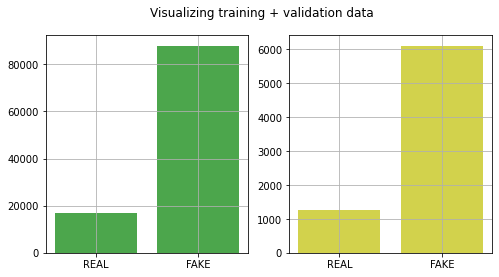

In [487]:
# Run the `data_prep_func` MLRun function locally
prep_data_run = data_prep_func.run(name='prep_data',
                                   handler=prep_data,
                                   inputs=config,
                                   local=True)

In [328]:
prep_data_run.state()

'completed'

In [333]:
train_dataset = mlrun.run.get_dataitem(prep_data_run.outputs['deepfake_dataset_train']).as_df()
val_dataset = mlrun.run.get_dataitem(prep_data_run.outputs['deepfake_dataset_val']).as_df()

X, y = train_dataset['paths'].values, train_dataset['labels'].values
val_X, val_y = val_dataset['paths'].values, val_dataset['labels'].values

## Boilerplate code to read images and balance the dataset using the FFHQ face dataset

In [336]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

import random
def get_random_sampling(paths, y, val_paths, val_y, num_train_samples = None, num_val_samples = None):
    real=[]
    fake=[]
    for m,n in zip(paths,y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
  # fake=random.sample(fake,len(real))
    paths,y=[],[]
    for x in real:
        paths.append(x)
        y.append(0)
    for x in fake:
        paths.append(x)
        y.append(1)

    real=[]
    fake=[]
    
    for m,n in zip(val_paths,val_y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
    
    
    val_paths,val_y=[],[]
    for x in real:
        val_paths.append(x)
        val_y.append(0)
    for x in fake:
        val_paths.append(x)
        val_y.append(1)

    X=[]
    for img in tqdm(paths):
        X.append(img)
    val_X=[]
    for img in tqdm(val_paths):
        val_X.append(img)

  # Balance with ffhq dataset
    ffhq = os.listdir('training_data/ffhq/thumbnails128x128')
    X_ = []
    for file in tqdm(ffhq):
        path = f'training_data/ffhq/thumbnails128x128/{file}'
        X_.append(path)
    random.shuffle(X_)

    for i in range(64773 - 12130):
        X.append(X_[i])
        y.append(0)
    
    
    del X_[0:64773 - 12130]


    for i in range(6108 - 1258):
        val_X.append(X_[i])
        val_y.append(0)

    X, y = shuffle(X,y)
    val_X, val_y = shuffle(val_X,val_y)
    
    if num_train_samples is not None:
        
        X, y = X[:num_train_samples], y[:num_train_samples]
        
    if num_val_samples is not None:
        
        val_X, val_y = X[:num_val_samples], y[:num_val_samples]

    return X, val_X, y, val_y

In [337]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, x, y, training=True, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.x[idx]
        
        img_numpy = read_img(img_path)
#         print(img_numpy.max(), img_numpy.min())

        if self.transform is not None:
            res = self.transform(image=img_numpy)
            img_numpy = res['image']
            
        img_tensor = torch.tensor(img_numpy).permute(-1,0,1)
        

        labels = self.y[idx]
        return {
            'image': img_tensor,
            'label': labels
        }

## (optional) Clipping training data 

Due to limited computational capabilities, you might not be able to train on the whole dataset. If that's the case then set `num_train_samples` and `num_val_samples` accordingly with small numbers which your machine can handle. 

In [340]:
X, val_X, Y, val_Y = get_random_sampling(
    paths, 
    y, 
    val_paths,
    val_y, 
    num_train_samples= 100, # Set this to None or simply skip this cell if you want to train on the whole dataset
    num_val_samples= 50     # Set this to None or simply skip this cell if you want to train on the whole dataset
)

len(X), len(val_X), len(Y), len(val_Y)

## Preparing our model

In [341]:
from pytorchcv.model_provider import get_model as ptcv_get_model
model = ptcv_get_model("efficientnet_b4")
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))


In [342]:
class Head(torch.nn.Module):
    def __init__(self, in_f, out_f):
        super(Head, self).__init__()

        self.f = nn.Flatten()
        self.l = nn.Linear(in_f, 512)
        self.d = nn.Dropout(0.75)
        self.o = nn.Linear(512, out_f)
        self.b1 = nn.BatchNorm1d(in_f)
        self.b2 = nn.BatchNorm1d(512)
        self.r = nn.ReLU()

    def forward(self, x):
#         print(x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.b1(x)
        x = self.d(x)

        x = self.l(x)
        x = self.r(x)
        x = self.b2(x)
        x = self.d(x)

        out = self.o(x)
        return out
    
class FCN(torch.nn.Module):
    def __init__(self, base, in_f):
        super(FCN, self).__init__()
        self.base = base
        self.h1 = Head(in_f, 1)
  
    def forward(self, x):
        x = self.base(x)
        return self.h1(x)



## Defining image augmentations 

In [358]:
import albumentations
from albumentations import (
    ShiftScaleRotate, 
    HorizontalFlip, 
    Normalize, 
    GaussNoise, 
)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = albumentations.Compose([
                                          ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          GaussNoise(p=.2),
                                          Normalize(mean = mean, std = std),
                                          albumentations.augmentations.geometric.resize.Resize(128,128)
])
val_transform = albumentations.Compose([
                                          Normalize(mean = mean, std = std),
                                          albumentations.augmentations.geometric.resize.Resize(128,128)
])

train_dataset = ImageDataset(X, Y, transform=train_transform)
val_dataset = ImageDataset(val_X, val_Y, transform=val_transform)

In [359]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## Visualizing training samples 

In [360]:
import torchvision.transforms as transforms
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])                             

def image_tensor_to_rgb(image_tensor, inverse_transform = invTrans ):
    return inverse_transform(image_tensor).permute(1,2,0).cpu().detach()

In [361]:
pair = next(iter(train_loader))


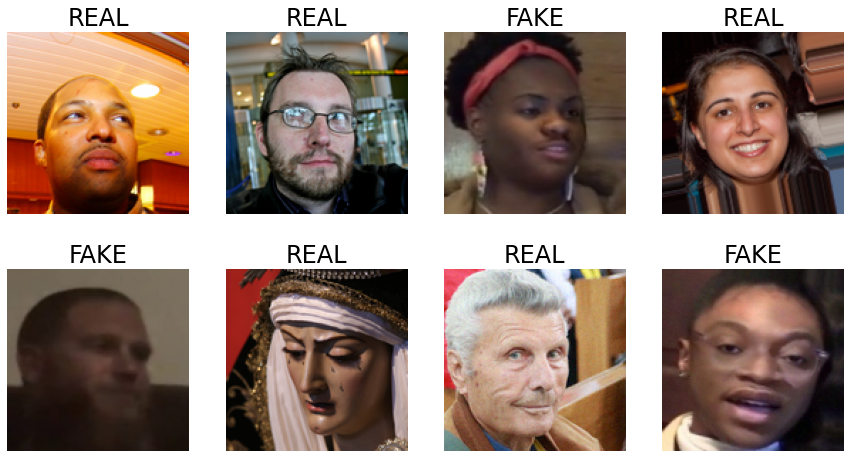

In [362]:
nrow, ncol = 2, 4
fig, ax = plt.subplots(nrow, ncol, figsize=(15,8))

for i in range(8):
    image = image_tensor_to_rgb(pair['image'][i])
    ax.flat[i].imshow(image)
    ax.flat[i].set_title('FAKE' if pair['label'][i].item() == 1 else 'REAL', fontsize = 24)
    ax.flat[i].axis('off')

In [363]:
def criterion(pred1, targets):
    l1 = F.binary_cross_entropy(F.sigmoid(pred1).squeeze(-1), targets)
    return l1

def train_model(model, epoch, optimizer, scheduler, loss ):
    model.train()
    total_loss = 0

    t = tqdm(train_loader, disable = True)
    for i, batch in enumerate(train_loader):
        
        img_batch = batch['image']
        img_batch = img_batch.cuda()

        y_batch = batch['label']
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion(out, y_batch)
        

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        loss.backward()
        optimizer.step()
        
    scheduler.step(1.)

    return model, total_loss


In [365]:
def get_model():
    model = ptcv_get_model("efficientnet_b4")
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    model = FCN(model, 1792)
    model = model.cuda()
    
    return model

## Hyperparameter grid search with `mlrun`

In [373]:
MAX_LR = 1e-2
MIN_LR = 9e-4
NUM_SAMPLES_LR = 100

MAX_BATCH_SIZE = 64
MIN_BATCH_SIZE = 32

possible_learning_rates = list(np.linspace(MIN_LR, MAX_LR, NUM_SAMPLES_LR))
possible_batch_sizes = [i for i in range(MIN_BATCH_SIZE, MAX_BATCH_SIZE+1, 1)]

In [371]:
import mlrun

def experiment(context, batch_size, learning_rate):
    
    model = get_model()
    optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    model, loss = train_model(model, 0,optimizer, scheduler, loss = criterion)
    
    context.logger.info(f"batch_size = {batch_size} learning_rate = {learning_rate} loss = {loss}")
    context.log_result("loss", loss.item())
    
grid_params = {
    "batch_size": possible_batch_sizes, 
    "learning_rate": possible_learning_rates
}

task = mlrun.new_task("deep-shield-grid-search-hyperparams").with_hyper_params(grid_params, selector="min.loss")
run = mlrun.new_function().run(task, handler=experiment)
## output removed 

In [370]:
run.show()

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield-mayukh,...c80f77,0,Jul 02 18:41:45,completed,deep-shield-grid-search-hyperparams,kind=handlerowner=mayukh,,,best_iteration=7loss=7.316556930541992,iteration_results


In [38]:
best_iter = results[results['output.loss'] == results['output.loss'].min()]

ideal_params = {
    'learning_rate': best_iter['param.learning_rate'].values[0],
    'batch_size': best_iter['param.batch_size'].values[0]
}

ideal_params

{'learning_rate': 0.002508, 'batch_size': 39}

# Init training 

In [883]:
# mlrun: start-code

In [884]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

from pytorchcv.model_provider import get_model as ptcv_get_model
import gc 
import random
from torch.utils.data import Dataset, DataLoader


In [885]:

class ImageDataset(Dataset):
    def __init__(self, x, y, training=True, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.x[idx]
        
        img_numpy = read_img(img_path)
#         print(img_numpy.max(), img_numpy.min())

        if self.transform is not None:
            res = self.transform(image=img_numpy)
            img_numpy = res['image']
            
        img_tensor = torch.tensor(img_numpy).permute(-1,0,1)
        

        labels = self.y[idx]
        return {
            'image': img_tensor,
            'label': labels
        }

In [886]:
class Head(torch.nn.Module):
    def __init__(self, in_f, out_f):
        super(Head, self).__init__()

        self.f = nn.Flatten()
        self.l = nn.Linear(in_f, 512)
        self.d = nn.Dropout(0.75)
        self.o = nn.Linear(512, out_f)
        self.b1 = nn.BatchNorm1d(in_f)
        self.b2 = nn.BatchNorm1d(512)
        self.r = nn.ReLU()

    def forward(self, x):
#         print(x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.b1(x)
        x = self.d(x)

        x = self.l(x)
        x = self.r(x)
        x = self.b2(x)
        x = self.d(x)

        out = self.o(x)
        return out
    
class FCN(torch.nn.Module):
    def __init__(self, base, in_f):
        super(FCN, self).__init__()
        self.base = base
        self.h1 = Head(in_f, 1)
  
    def forward(self, x):
        x = self.base(x)
        return self.h1(x)


In [887]:


def get_model():
    model = ptcv_get_model("efficientnet_b4")
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    model = FCN(model, 1792)
    model = model.cuda()
    
    return model

In [888]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y


def get_random_sampling(paths, y, val_paths, val_y, num_train_samples = None, num_val_samples = None):
    real=[]
    fake=[]
    for m,n in zip(paths,y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
  # fake=random.sample(fake,len(real))
    paths,y=[],[]
    for x in real:
        paths.append(x)
        y.append(0)
    for x in fake:
        paths.append(x)
        y.append(1)

    real=[]
    fake=[]
    
    for m,n in zip(val_paths,val_y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
    
    
    val_paths,val_y=[],[]
    for x in real:
        val_paths.append(x)
        val_y.append(0)
    for x in fake:
        val_paths.append(x)
        val_y.append(1)

    X=[]
    for img in tqdm(paths):
        X.append(img)
    val_X=[]
    for img in tqdm(val_paths):
        val_X.append(img)

  # Balance with ffhq dataset
    ffhq = os.listdir('training_data/ffhq/thumbnails128x128')
    X_ = []
    for file in tqdm(ffhq):
        path = f'training_data/ffhq/thumbnails128x128/{file}'
        X_.append(path)
    random.shuffle(X_)

    for i in range(64773 - 12130):
        X.append(X_[i])
        y.append(0)
    
    
    del X_[0:64773 - 12130]


    for i in range(6108 - 1258):
        val_X.append(X_[i])
        val_y.append(0)

    X, y = shuffle(X,y)
    val_X, val_y = shuffle(val_X,val_y)
    
    if num_train_samples is not None:
        
        X, y = X[:num_train_samples], y[:num_train_samples]
        
    if num_val_samples is not None:
        
        val_X, val_y = X[:num_val_samples], y[:num_val_samples]

    return X, val_X, y, val_y

def train_n_epochs(model, num_epochs , train_loader, val_loader, checkpoint_name = 'model.pth', lr = 0.001, loss = None, context = None):
    
    best_acc = 0.
    accuracies = []
    losses = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        gc.collect()

        model, loss = train_model(model, epoch, optimizer, scheduler, loss = loss, train_loader= train_loader)
        losses.append(loss)
        
        acc = evaluate_model(model, val_loader)
        accuracies.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            print(f'Saving best model: {checkpoint_name}')
            torch.save(model.state_dict(), checkpoint_name)
            
        if context is not None:
            context.logger.info(f'epoch: {epoch+1} current acc: {round(acc, 4)} best acc: {round(best_acc, 4)}')
            
            
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
    
    ax[0].plot(losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    
    ax[1].plot(accuracies)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    
    context.log_artifact(PlotArtifact('training logs', body=fig))

    return model

In [889]:

def evaluate_model(model, val_loader):
    model.eval()
    pred = []
    real = []
    with torch.no_grad():
        for batch in val_loader:
        
            img_batch, y_batch = batch['image'].cuda().float(), batch['label'].cuda().float()

            o1 = model(img_batch)
            
            for j in o1:
                pred.append(F.sigmoid(j))
                
            for i in y_batch:
                real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    return acc

def criterion(pred1, targets):
    l1 = F.binary_cross_entropy(F.sigmoid(pred1).squeeze(-1), targets)
    return l1

def train_model(model, epoch, optimizer, scheduler, loss , train_loader):
    model.train()
    total_loss = 0

    t = tqdm(train_loader, disable = True)
    for i, batch in enumerate(train_loader):
        
        img_batch = batch['image']
        img_batch = img_batch.cuda()

        y_batch = batch['label']
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion(out, y_batch)
        

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        loss.backward()
        optimizer.step()
        
    scheduler.step(1.)

    return model, total_loss

In [890]:
from mlrun.mlutils.data import get_sample
import pandas as pd 
import albumentations
from albumentations import (
    ShiftScaleRotate, 
    HorizontalFlip, 
    Normalize, 
    GaussNoise, 
)

def get_training_data(train_dataset: DataItem, val_dataset: DataItem, 
                      label_column = 'labels', df_train_path = 'df_train.csv',
                      df_val_path = 'df_val.csv', ideal_params = None): 
    
    df_train = pd.read_csv(df_train_path)
    df_val = pd.read_csv(df_val_path)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transform = albumentations.Compose([
        ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
        HorizontalFlip(p=0.2),
        GaussNoise(p=.2),
        Normalize(mean = mean, std = std),
        albumentations.augmentations.geometric.resize.Resize(128,128)
    ])
    
    val_transform = albumentations.Compose([
      Normalize(mean = mean, std = std),
      albumentations.augmentations.geometric.resize.Resize(128,128)
    ])

        
    raw, labels, header = get_sample(train_dataset, sample=-1, label=label_column)
    raw_val, labels_val, header = get_sample(train_dataset, sample=-1, label=label_column)

    print(raw, labels)
    
    

    X, y = raw['paths'].values, labels.values
    val_X, val_y = raw_val['paths'].values, labels_val.values

    X, val_X, Y, val_Y = get_random_sampling(
        df_train['paths'].values, 
        df_train['labels'].values, 
        df_val['paths'].values,
        df_val['labels'].values, 
        num_train_samples= 100, # Set this to None if you want to train on the whole dataset
        num_val_samples= 50     # Set this to None if you want to train on the whole dataset
    )

    train_dataset = ImageDataset(X, Y, transform=train_transform)
    val_dataset = ImageDataset(val_X, val_Y, transform=val_transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=ideal_params['batch_size'], shuffle=True, num_workers=4)
    val_loader = DataLoader(dataset=val_dataset, batch_size= 10, shuffle=False, num_workers=0)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader
    }



def train_model_auto(context, train_dataset: DataItem, val_dataset: DataItem, 
                     num_epochs, hyperparams, checkpoint_name, df_train_path, df_val_path):
    
    print("started training :)")
    
    data = get_training_data(
        train_dataset= train_dataset,
        val_dataset= val_dataset,
        df_train_path = df_train_path,
        df_val_path = df_val_path,
        ideal_params= hyperparams
    )
    
    model = get_model()
    
    train_n_epochs(
        model = model,
        num_epochs = num_epochs,
        train_loader= data['train_loader'],
        val_loader=  data['val_loader'],
        lr = hyperparams['learning_rate'],
        loss = criterion,
        checkpoint_name = checkpoint_name,
        context = context  ## context passed into fn
    )
    

In [891]:
# mlrun: end-code

In [892]:
train_func = mlrun.code_to_function(
    name='train_model_auto',
    kind='job',
    image='mlrun/mlrun'
)

## Training the model with `mlrun`

In [893]:
train_dataset = f'store://{project_name}/prep_data_deepfake_dataset_train'
val_dataset = f'store://{project_name}/prep_data_deepfake_dataset_val'

> 2021-07-03 03:14:57,381 [info] starting run train_model_auto uid=d5be88f69ae64130916ba8a411ad43ad DB=./api_dir
started training :)


100%|██████████| 70000/70000 [00:00<00:00, 3827318.80it/s]

                                                    paths
0       training_data/archive/DeepFake00/DeepFake00/vp...
1       training_data/archive/DeepFake00/DeepFake00/fz...
2       training_data/archive/DeepFake00/DeepFake00/ht...
3       training_data/archive/DeepFake00/DeepFake00/fc...
4       training_data/archive/DeepFake00/DeepFake00/sp...
...                                                   ...
104884  training_data/archive/DeepFake46/DeepFake46/ng...
104885  training_data/archive/DeepFake46/DeepFake46/vg...
104886  training_data/archive/DeepFake46/DeepFake46/vp...
104887  training_data/archive/DeepFake46/DeepFake46/tk...
104888  training_data/archive/DeepFake46/DeepFake46/wd...

[104889 rows x 1 columns] 0         0
1         0
2         1
3         1
4         1
         ..
104884    0
104885    1
104886    0
104887    0
104888    1
Name: labels, Length: 104889, dtype: int64


Saving best model: model.pt
> 2021-07-03 03:15:07,469 [info] epoch: 1 current acc: 0.5 best acc: 0.5
> 2021-07-03 03:15:10,586 [info] epoch: 2 current acc: 0.5 best acc: 0.5
> 2021-07-03 03:15:13,711 [info] epoch: 3 current acc: 0.5 best acc: 0.5
> 2021-07-03 03:15:16,831 [info] epoch: 4 current acc: 0.5 best acc: 0.5
> 2021-07-03 03:15:19,979 [info] epoch: 5 current acc: 0.5 best acc: 0.5


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield-mayukh,...ad43ad,0,Jul 02 21:44:57,completed,train_model_auto,kind=owner=mayukhhost=leopard,train_datasetval_dataset,"num_epochs=5hyperparams={'learning_rate': 0.002508, 'batch_size': 39}checkpoint_name=model.ptdf_train_path=df_train.csvdf_val_path=df_val.csv",,training logs


to track results use .show() or .logs() or in CLI: 
!mlrun get run d5be88f69ae64130916ba8a411ad43ad --project deepfake-shield-mayukh , !mlrun logs d5be88f69ae64130916ba8a411ad43ad --project deepfake-shield-mayukh
> 2021-07-03 03:15:20,195 [info] run executed, status=completed


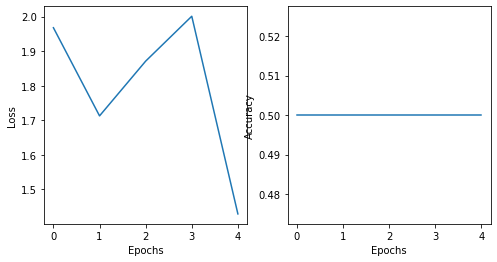

In [894]:
params = {
    'num_epochs':5,
    'hyperparams': ideal_params,
    'checkpoint_name': 'model.pt',
    'df_train_path': 'df_train.csv',
    'df_val_path': 'df_val.csv'
}

inputs = {
    'train_dataset': train_dataset,
    'val_dataset': val_dataset
    
}

train_run = train_func.run(name='train_model_auto',
                                   handler=train_model_auto,
                                   inputs=inputs,
                                   params = params,
                                   local=True)

In [216]:
best_model = get_model()
best_model.load_state_dict(torch.load(PARAMS['checkpoint_name']))

acc = evaluate_model(model = best_model.cuda(), val_loader = val_loader)
print(f'final accuracy: {acc}')

final accuracy: 0.9791666666666667
